# Yelp reviews exploratory analysis


Overall goals: 
1) Predict a new reviewer's rating of a business. 
2) Extract the key words/sentiments for strongly positive/negative reviews to identify strong/weak points in the services a business provides to customers.

This exploratory notebook will take a first look at the Yelp Dataset from: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset. Contains a subset of Yelp's businesses, reviews, and user data. ~4 GB of data in JSON format.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import json

sns.set_style('white')
%matplotlib inline

pd.set_option('display.max_columns', None)

## Loading & combining a subset of the data

In [2]:
#This notebook explores data with a subset of 100,000 data points
#In total, there are 6.9m data points which will be batch processed later on in 3_batch_process.py
review = pd.read_json('../archive/yelp_academic_dataset_review.json',
                     lines = True,
                     orient = 'columns',
                     chunksize = 100000)
for i in review:
    review_subset = i
    break
    
business = pd.read_json('../archive/yelp_academic_dataset_business.json',
                     lines = True,
                     orient = 'columns',
                     chunksize = 100000)
for i in business:
    business_subset = i
    break

In [3]:
review_subset.rename(columns={'stars':'review stars'}, inplace=True) #eventual target column
review_subset.head(2)
review_subset.info()
# ~10000 unique business id's reviewed in this subset
review_subset['business_id'].nunique() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   review_id     100000 non-null  object        
 1   user_id       100000 non-null  object        
 2   business_id   100000 non-null  object        
 3   review stars  100000 non-null  int64         
 4   useful        100000 non-null  int64         
 5   funny         100000 non-null  int64         
 6   cool          100000 non-null  int64         
 7   text          100000 non-null  object        
 8   date          100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 6.9+ MB


9973

In [4]:
business_subset.rename(columns={'stars':'business stars'}, inplace=True) #average stars for a business
business_subset.head(2)
business_subset.info()
business_subset['business_id'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   business_id     100000 non-null  object 
 1   name            100000 non-null  object 
 2   address         100000 non-null  object 
 3   city            100000 non-null  object 
 4   state           100000 non-null  object 
 5   postal_code     100000 non-null  object 
 6   latitude        100000 non-null  float64
 7   longitude       100000 non-null  float64
 8   business stars  100000 non-null  float64
 9   review_count    100000 non-null  int64  
 10  is_open         100000 non-null  int64  
 11  attributes      90915 non-null   object 
 12  categories      99931 non-null   object 
 13  hours           84564 non-null   object 
dtypes: float64(3), int64(2), object(9)
memory usage: 10.7+ MB


100000

In [5]:
#join reviews with their corresponding business information
business_reviews = review_subset.merge(business_subset, on='business_id')
business_reviews.head(2)
business_reviews.info()
business_reviews['business_id'].nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   review_id       100000 non-null  object        
 1   user_id         100000 non-null  object        
 2   business_id     100000 non-null  object        
 3   review stars    100000 non-null  int64         
 4   useful          100000 non-null  int64         
 5   funny           100000 non-null  int64         
 6   cool            100000 non-null  int64         
 7   text            100000 non-null  object        
 8   date            100000 non-null  datetime64[ns]
 9   name            100000 non-null  object        
 10  address         100000 non-null  object        
 11  city            100000 non-null  object        
 12  state           100000 non-null  object        
 13  postal_code     100000 non-null  object        
 14  latitude        100000 non-null  floa

9973

## Exploratory data analysis & feature extractions

We are going to try to predict the likelihood a review will be positive (4-5 stars), neutral (3 stars), or negative (1-2 stars)
   - Target: business_reviews['review stars']
    
    
Lets take a closer look at the important features in business_reviews:

In [6]:
#We can drop extra features.
    #Textual review content superceeds individual reviewer/user information
    #The main business information we need is the avergage stars per business_id,
        #which is already in column 'business stars' and 'review_count'
    #Additional business type will be encoded later on in this file
    #Location will be encoded later on with k-means clustering from latitude/longitude
    
drop_features = ['review_id', 'user_id', 'business_id', 'name', 'address',
                'city', 'is_open', 'attributes', 'hours', 'postal_code']

business_reviews.drop(columns=drop_features, inplace=True)
business_reviews = business_reviews.dropna().reset_index(drop=True) 

#Add in datetime features as separate columns, remove date column
business_reviews['year'] = [datetime.year for datetime in business_reviews['date']]
business_reviews['month'] = [datetime.month for datetime in business_reviews['date']]
business_reviews['hour'] = [datetime.hour for datetime in business_reviews['date']]
business_reviews.drop(columns='date', inplace=True)

In [7]:
business_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99996 entries, 0 to 99995
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review stars    99996 non-null  int64  
 1   useful          99996 non-null  int64  
 2   funny           99996 non-null  int64  
 3   cool            99996 non-null  int64  
 4   text            99996 non-null  object 
 5   state           99996 non-null  object 
 6   latitude        99996 non-null  float64
 7   longitude       99996 non-null  float64
 8   business stars  99996 non-null  float64
 9   review_count    99996 non-null  int64  
 10  categories      99996 non-null  object 
 11  year            99996 non-null  int64  
 12  month           99996 non-null  int64  
 13  hour            99996 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 10.7+ MB


In [8]:
business_reviews.describe()

,review stars,useful,funny,cool,latitude,longitude,business stars,review_count,year,month,hour
count,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000
mean,3.842994,0.899016,0.257190,0.347044,36.070751,-89.004495,3.770831,386.511940,2014.851854,6.287181,12.847974
std,1.354667,2.205222,1.010231,1.066402,5.297937,14.436770,0.672913,621.866175,2.438264,3.318411,7.907023
min,1.000000,0.000000,0.000000,0.000000,27.555127,-120.095137,1.000000,5.000000,2005.000000,1.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,29.968642,-90.240317,3.500000,60.000000,2013.000000,3.000000,4.000000
50%,4.000000,0.000000,0.000000,0.000000,38.612945,-86.241899,4.000000,169.000000,2015.000000,6.000000,16.000000
75%,5.000000,1.000000,0.000000,0.000000,39.946685,-75.325628,4.000000,427.000000,2017.000000,9.000000,19.000000
max,5.000000,320.000000,98.000000,49.000000,53.644501,-74.658572,5.000000,4554.000000,2018.000000,12.000000,23.000000


<Axes: xlabel='review stars', ylabel='count'>

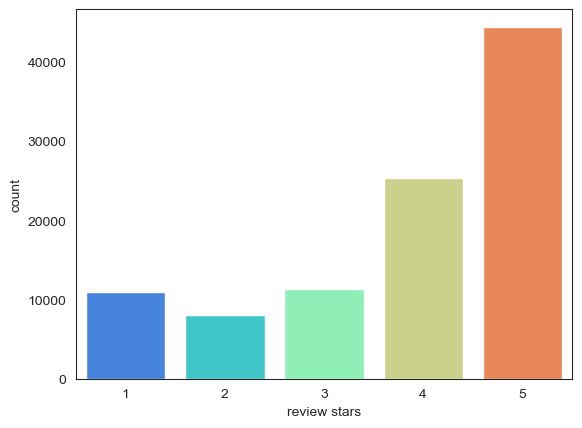

In [9]:
#Countplot of review stars: shows most reviews are positive (4-5)
sns.countplot(x='review stars', data=business_reviews, palette='rainbow')

In [10]:
#Use groupby to see if significant variations appear between star ratings
stars = business_reviews.groupby('review stars').mean(numeric_only=True)
stars

,useful,funny,cool,latitude,longitude,business stars,review_count,year,month,hour
review stars,,,,,,,,,,
1,1.436527,0.438542,0.146639,36.234915,-88.667736,3.108536,223.508610,2015.234017,6.384869,12.502656
2,1.130946,0.374311,0.221082,36.428850,-88.249412,3.444166,332.552328,2014.663245,6.263395,12.632824
3,0.839289,0.295635,0.308308,36.366561,-88.439060,3.582248,401.331544,2014.333216,6.207182,12.758229
4,0.846937,0.253079,0.450900,36.276677,-88.495824,3.783450,428.570966,2014.314651,6.268235,12.872908
5,0.770094,0.184020,0.369639,35.772697,-89.658228,4.033565,408.513921,2015.231145,6.298725,12.980357


<Axes: >

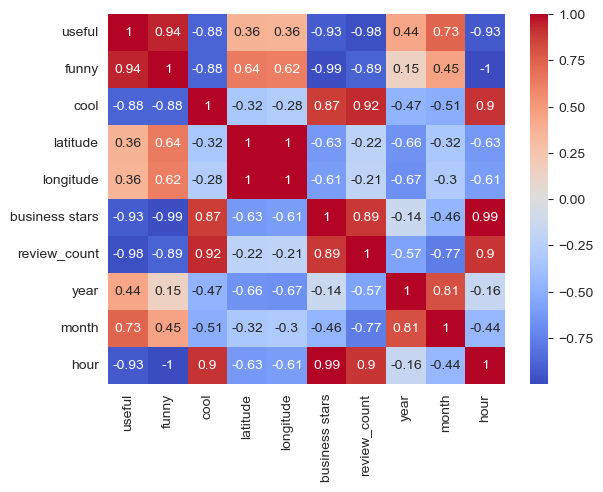

In [11]:
#Visualize correlations between features and stars
stars.corr(numeric_only=True)
sns.heatmap(stars.corr(), cmap='coolwarm', annot=True)

## Feature engineering: 
Before we go too much further, we need to do some analysis & feature extraction.
### 1) Review text analysis
The review text will be analyzed below for:
1) text length
2) sentence count
3) sentiment analysis:
    - (a) using a pretrained roBERTa model on 58M tweets from Twitter
        - returns positive, neutral, or negative sentiment & sentiment score
            - https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment
    - (b) fine tuned a bert-base-uncased model
        - a bert-base uncased model was fine tuned on 50k reviews & review stars from this data set (see 2_review_text_fine_tune.py)
            - https://huggingface.co/bert-base-uncased
        - returns scores for each of positive, neutral, and negative sentiments
    - We can then compare how well a pretrained model vs. fine tuned model work for this analysis

In [12]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import datasets 
import torch

#Initialize NLP models

#Pretrained roBERTa model pipeline and utilize cuda computing with device=0
model_roberta = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'
pipe_roberta = pipeline('sentiment-analysis', 
                        model=model_roberta, 
                        tokenizer=model_roberta, 
                        device_map='auto') #auto uses Accelerate to choose cpu/gpu map

#Finetuned bert-base-uncased model on 50k reviews, see 2_review_text_fine_tune.py
path = r'C:\Users\mitch\.cache\huggingface\hub'
model_finetuned_name = path + r'\models--bert-base-uncased-YR-finetuned'
model_finetuned = AutoModelForSequenceClassification.from_pretrained(model_finetuned_name, num_labels=3)
model_tokens = 'bert-base-uncased'
tokenizer_finetuned = AutoTokenizer.from_pretrained(model_tokens)
config = AutoConfig.from_pretrained(model_finetuned_name)
model_finetuned.to('cuda')

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
#Test the models.
text_test = 'It was ok. Some people told us this was the place to eat at. We were sort of disappointed.'

#roBERTa pipeline
roberta_test = pipe_roberta(text_test)
print('roBERTa pretrained:', roberta_test[0])

#Fine tuned model
inputs_finetuned = tokenizer_finetuned(text_test, padding=True, truncation=True, return_tensors='pt').to('cuda')
outputs_finetuned = model_finetuned(**inputs_finetuned)
prediction_finetuned = torch.nn.functional.softmax(outputs_finetuned.logits, dim=-1).cpu().detach().numpy()[0]
print(f'BERT finetuned: negative {prediction_finetuned[0]}, neutral {prediction_finetuned[1]}, positive {prediction_finetuned[2]}')
      
print('''\nWe can see there are differences in model outputs already. 
The finetuned model seems to point toward a more neutral stance than the pretrained model.''')

roBERTa pretrained: {'label': 'negative', 'score': 0.8796820044517517}
BERT finetuned: negative 0.016171744093298912, neutral 0.9606575965881348, positive 0.023170653730630875

We can see there are differences in model outputs already. 
The finetuned model seems to point toward a more neutral stance than the pretrained model.


In [14]:
from text_preprocess import TextPrepare
#Evaluate all text reviews using 3_1_text_preprocess.py module TextPrepare method
    
#We need the score and the sentiment encoded as:
    # Positive = 2
    # Neutral = 1
    # Negative = 0

#Sending the text, dictionary, and max string length to TextPrepare
text_input = business_reviews['text']
sentiment_dictionary = {'positive': 2, 'neutral': 1, 'negative': 0}
max_text_length = 1000 #splits into multiple text sections, each of which are evaluated

#Loop returns:
    #length, sentence count
    #roBERTA: sentiment, score 
    #fine tuned (ft) BERT: positive score, neutral score, negative score

text_information = []
for i in range(0, len(text_input)):
    
    text_info = TextPrepare(text_input[i])
    text_info.strip()
    text_info.roberta_fit(pipe_roberta, sentiment_dictionary, max_text_length)
    text_info.ft_bert_fit(tokenizer_finetuned, model_finetuned)
    
    text_information.append([text_info.length,
                             text_info.sentence_count,
                             
                             text_info.sentiment_value, 
                             text_info.score, 
                            
                             text_info.ft_positive,
                             text_info.ft_neutral,
                             text_info.ft_negative
                            ])

#Create a text_analyzed dataframe to join with the other features    
col_names =  ['length', 'sentence count', #generic text info
              'pt sentiment', 'pt sentiment score', #pretrained roBERTa output
              'ft positive', 'ft neutral', 'ft negative'] #finetuned BERT output
text_analyzed = pd.DataFrame(text_information, columns=col_names)

#Combine with business_reviews dataframe
business_reviews = business_reviews.merge(text_analyzed, left_index=True, right_index=True)

# Further feature engineering:

In [15]:
#Current features:
business_reviews.head(5)

,review stars,useful,funny,cool,text,state,latitude,longitude,business stars,review_count,categories,year,month,hour,length,sentence count,pt sentiment,pt sentiment score,ft positive,ft neutral,ft negative
0,3,0,0,0,"If you decide to eat here, just be aware it is...",PA,40.210196,-75.223639,3.0,169,"Restaurants, Breakfast & Brunch, Food, Juice B...",2018,7,22,513,7,0.0,0.435837,0.023872,0.952052,0.024076
1,2,0,0,0,This is the second time we tried turning point...,PA,40.210196,-75.223639,3.0,169,"Restaurants, Breakfast & Brunch, Food, Juice B...",2017,5,17,477,5,0.0,0.584281,0.001242,0.015716,0.983042
2,4,2,0,1,The place is cute and the staff was very frien...,PA,40.210196,-75.223639,3.0,169,"Restaurants, Breakfast & Brunch, Food, Juice B...",2017,8,0,216,6,2.0,0.917206,0.987406,0.012208,0.000387
3,3,0,0,0,We came on a Saturday morning after waiting a ...,PA,40.210196,-75.223639,3.0,169,"Restaurants, Breakfast & Brunch, Food, Juice B...",2017,11,2,736,9,0.0,0.395230,0.005238,0.877663,0.117099
4,2,0,0,0,"Mediocre at best. The decor is very nice, and ...",PA,40.210196,-75.223639,3.0,169,"Restaurants, Breakfast & Brunch, Food, Juice B...",2017,9,17,953,9,0.0,0.614386,0.000472,0.011433,0.988096



### 1) Business type
- Goal: categorize reviews by a generic business type

In [16]:
#There are too many distinct business categories to directly work with
business_reviews['categories'].nunique()

7211

In [17]:
business_reviews['categories']

0        Restaurants, Breakfast & Brunch, Food, Juice B...
1        Restaurants, Breakfast & Brunch, Food, Juice B...
2        Restaurants, Breakfast & Brunch, Food, Juice B...
3        Restaurants, Breakfast & Brunch, Food, Juice B...
4        Restaurants, Breakfast & Brunch, Food, Juice B...
                               ...                        
99991    Event Planning & Services, Sporting Goods, Par...
99992                                   Pizza, Restaurants
99993    Cosmetics & Beauty Supply, Hair Stylists, Blow...
99994    Restaurants, Bars, Nightlife, American (Tradit...
99995    Comic Books, Toy Stores, Food, Bookstores, Cof...
Name: categories, Length: 99996, dtype: object

In [18]:
#Extract a more generic category for each review and one-hot encode them

#7 more generic subset category groups
food = ['food', 
        ['food',
        'restaurants']
       ]

shop = ['shop', 
        ['shopping',
        'automotive',
        'pets']      
       ]

housing = ['housing', 
           ['real estate']
          ]

education = ['education', 
             ['education']
            ]

entertainment = ['entertainment',
                 ['arts & entertainment', 
                 'beauty & spas',
                 'nightlife',
                 'local flavor',
                 'mass media',
                 'active life',
                 'hotels & travel',
                 'tours']
                ]

health = ['health',
          ['health & medical']
         ]

services = ['services',
            ['event planning & services',
            'financial services',
            'car rental',
            'home services',
            'local services',
            'professional services',
            'public services & government',
            'religious organizations']
           ]

category = [food, shop, housing, education, entertainment, health, services]

In [19]:
#Initialize a zeroes dataframe category_types
    #shape: (business_reviews, category) 
column_labels = ['food', 'shop', 'health', 'housing', 'education', 'entertainment',  'services']
category_types = pd.DataFrame(0, 
                     index=np.arange(len(business_reviews['categories'])),
                     columns=column_labels)

#Count the number of instances of category indication per review
for i in range(0, len(business_reviews['categories'])):
    for j in category:
        for k in j[1]:
            if k in business_reviews['categories'][i].lower().split(', '):
                category_types[j[0]][i] = 1

                
#Many places list multiple generic types, perhaps businesses with many service types. 
#This will introduce confusion into fitting & prediction, therefore 
#assign a primary type where:
    # food > shop > health > housing > education > entertainment > services
    #ex. an entry with both food & services will be assigned primary key food 
    #i.e., assign 0 to column value if any value to its left is nonzero
    
def primary_key(row):
    #find first nonzero instance index
    primary = np.where(row == 1)[0][0]
    #create array to set non-primary keys to 0
    mask = np.zeros(len(row))
    mask[primary] = 1
    return mask*row

for i in range(0, len(category_types)):
    category_types.loc[i] = primary_key(category_types.loc[i]) 

#We can see the majority of reviews are about food, second largest is entertainment
category_types.sum()

food             78353
shop              7400
health            1330
housing            319
education          212
entertainment    10710
services          1672
dtype: int64

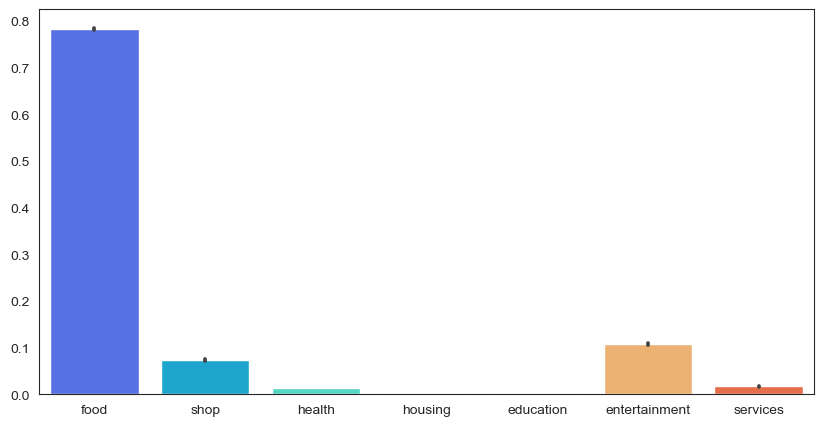

In [41]:
#Visualize this with a horizontal box plot
fig, ax = plt.subplots(figsize=(10,5))
g = sns.barplot(data=category_types, palette='rainbow', ax=ax)

In [42]:
#Merge one-hot encoded business types and remove original categories column
business_reviews = business_reviews.drop('categories',axis=1)
business_reviews = business_reviews.merge(category_types, left_index=True, right_index=True)

### 2) Location: K-means clustering by latitude/longitude

- Goal: reduce the number of geolocations below the number of unique states/cities with lat/long
- rescaling is not useful here, lat/long are in natural distances

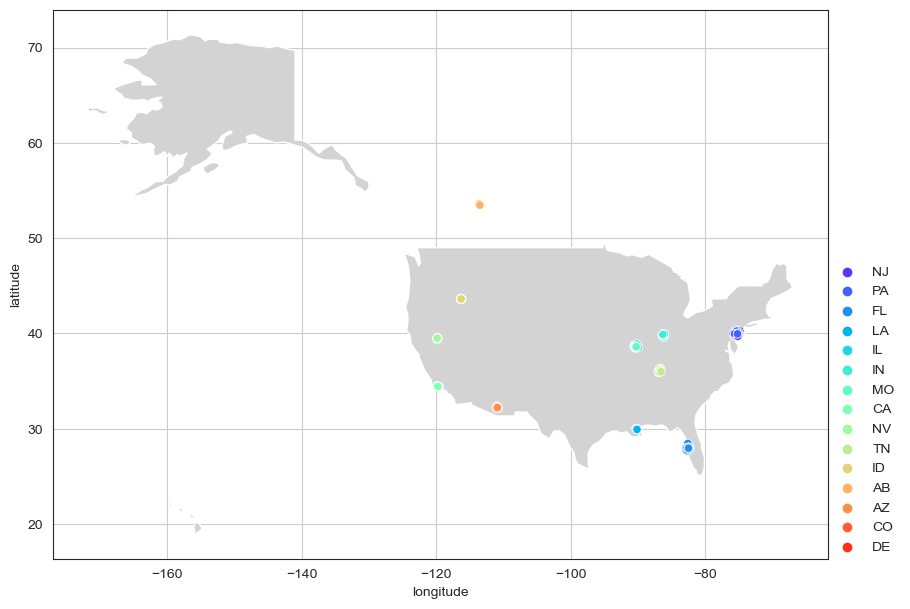

In [58]:
import geopandas as gpd

#Lets take a quick look at the arrangement of data geographically with a smaller sample of data:
df_subset = business_reviews[['latitude','longitude','state']].sample(n=1000)

fig, ax = plt.subplots(figsize=(10,8))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world[world['name'] == 'United States of America'].plot(color='lightgrey', ax=ax)

sns.scatterplot(data=df_subset, x='longitude', y='latitude', ax=ax, hue='state', palette='rainbow')

plt.grid()
plt.legend(loc=(1,0), framealpha=0)

#There appear to be ~11 smaller geographical clusters contained within the data

In [59]:
from sklearn.cluster import KMeans

#Clusters are far enough apart that identifying the cluster won't take many iterations or a lot of data
kmeans = KMeans(n_clusters = 11, n_init=10, random_state=0)
cluster = kmeans.fit(df_subset[['latitude','longitude']])

business_reviews['cluster'] = cluster.predict(business_reviews[['latitude','longitude']])

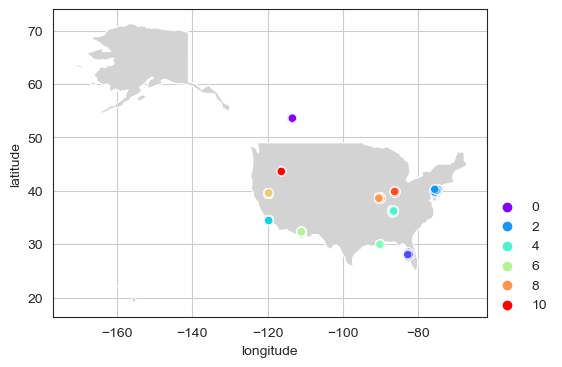

In [60]:
#Quick visual check that everything clustered 
fig, ax = plt.subplots(figsize=(10,4))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world[world['name'] == 'United States of America'].plot(color='lightgrey', ax=ax)

sns.scatterplot(data=business_reviews, x='longitude', y='latitude', ax=ax, hue='cluster', palette='rainbow')

plt.grid()
plt.legend(loc=(1,0), framealpha=0)

#Remove state, latitude, longitude
business_reviews = business_reviews.drop(columns=['state', 'latitude', 'longitude'])

In [61]:
#Save the model to use in batch_process.py of all reviews later on
import joblib
joblib.dump(kmeans, '../ML_models/kmeans_latlong.joblib')

['../ML_models/kmeans_latlong.joblib']

## Revisiting exploratory data analysis
Look again at the processed information and how review stars (the target) correlate with these engineered features

In [62]:
business_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99996 entries, 0 to 99995
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review stars        99996 non-null  int64  
 1   useful              99996 non-null  int64  
 2   funny               99996 non-null  int64  
 3   cool                99996 non-null  int64  
 4   text                99996 non-null  object 
 5   business stars      99996 non-null  float64
 6   review_count        99996 non-null  int64  
 7   year                99996 non-null  int64  
 8   month               99996 non-null  int64  
 9   hour                99996 non-null  int64  
 10  length              99996 non-null  int64  
 11  sentence count      99996 non-null  int64  
 12  pt sentiment        99996 non-null  float64
 13  pt sentiment score  99996 non-null  float64
 14  ft positive         99996 non-null  float32
 15  ft neutral          99996 non-null  float32
 16  ft n

In [63]:
business_reviews.describe()

,review stars,useful,funny,cool,business stars,review_count,year,month,hour,length,sentence count,pt sentiment,pt sentiment score,ft positive,ft neutral,ft negative,food,shop,health,housing,education,entertainment,services,cluster
count,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000,99996.000000
mean,3.842994,0.899016,0.257190,0.347044,3.770831,386.511940,2014.851854,6.287181,12.847974,548.428887,7.596764,1.228848,0.690212,0.709075,0.107767,0.183158,0.783561,0.074003,0.013301,0.003190,0.002120,0.107104,0.016721,4.010740
std,1.354667,2.205222,1.010231,1.066402,0.672913,621.866175,2.438264,3.318411,7.907023,501.709825,5.875067,0.928138,0.194395,0.439815,0.273394,0.372241,0.411819,0.261777,0.114559,0.056391,0.045996,0.309247,0.128223,2.671842
min,1.000000,0.000000,0.000000,0.000000,1.000000,5.000000,2005.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.333750,0.000348,0.000319,0.000103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,3.500000,60.000000,2013.000000,3.000000,4.000000,226.000000,4.000000,0.000000,0.503896,0.033238,0.000734,0.000147,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,4.000000,0.000000,0.000000,0.000000,4.000000,169.000000,2015.000000,6.000000,16.000000,395.000000,6.000000,2.000000,0.720529,0.996940,0.002577,0.000233,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,5.000000,1.000000,0.000000,0.000000,4.000000,427.000000,2017.000000,9.000000,19.000000,693.000000,9.000000,2.000000,0.877717,0.999126,0.013019,0.017809,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,5.000000,320.000000,98.000000,49.000000,5.000000,4554.000000,2018.000000,12.000000,23.000000,5000.000000,78.000000,2.000000,0.968329,0.999488,0.985500,0.997390,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


In [64]:
#Use groupby to see if significant variations appear between ratings
stars = business_reviews.groupby('review stars').mean(numeric_only=True)
stars

,useful,funny,cool,business stars,review_count,year,month,hour,length,sentence count,pt sentiment,pt sentiment score,ft positive,ft neutral,ft negative,food,shop,health,housing,education,entertainment,services,cluster
review stars,,,,,,,,,,,,,,,,,,,,,,,
1,1.436527,0.438542,0.146639,3.108536,223.508610,2015.234017,6.384869,12.502656,673.699304,8.736032,0.081650,0.764412,0.016536,0.033110,0.950355,0.701319,0.113116,0.013922,0.010533,0.002290,0.126763,0.032057,3.924070
2,1.130946,0.374311,0.221082,3.444166,332.552328,2014.663245,6.263395,12.632824,685.536680,8.953430,0.184041,0.677774,0.033603,0.218786,0.747611,0.838883,0.047071,0.007011,0.000876,0.001878,0.096395,0.007887,3.935653
3,0.839289,0.295635,0.308308,3.582248,401.331544,2014.333216,6.207182,12.758229,647.486270,8.553248,0.692400,0.596026,0.270506,0.588056,0.141438,0.850114,0.041630,0.004313,0.001408,0.001056,0.096198,0.005281,3.975092
4,0.846937,0.253079,0.450900,3.783450,428.570966,2014.314651,6.268235,12.872908,561.568677,7.733383,1.416691,0.640518,0.925899,0.065888,0.008213,0.844135,0.046140,0.006473,0.001539,0.001816,0.093266,0.006631,4.002052
5,0.770094,0.184020,0.369639,4.033565,408.513921,2015.231145,6.298725,12.980357,460.094972,6.749662,1.729095,0.726669,0.989450,0.007125,0.003425,0.742228,0.093418,0.020477,0.003199,0.002568,0.114886,0.023225,4.059650


<Axes: >

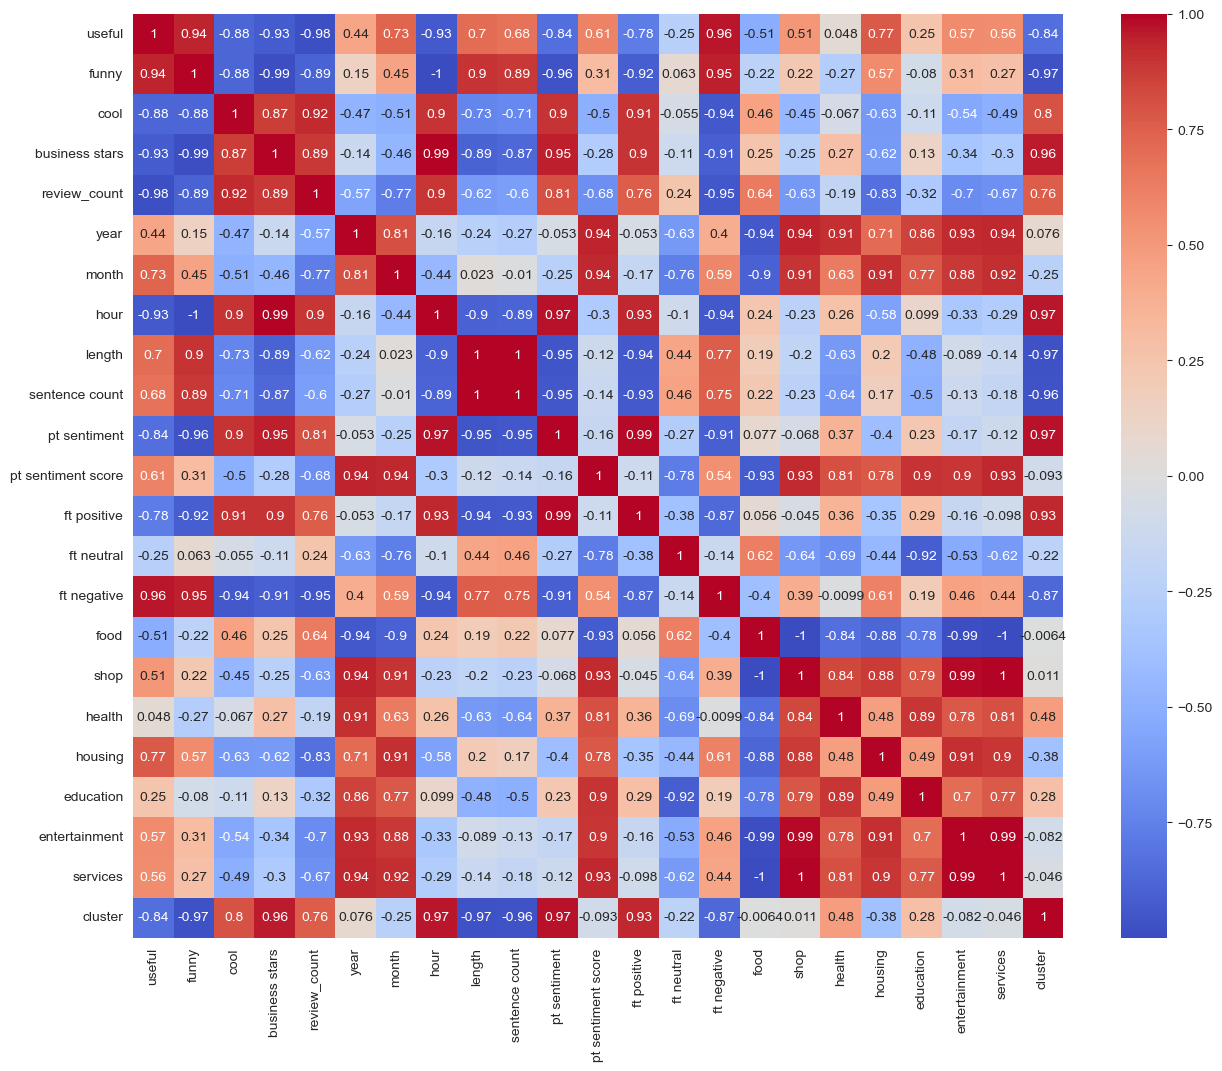

In [68]:
#Visualize correlations between features and stars
fig, ax = plt.subplots(figsize=(15,12))
stars.corr(numeric_only=True)
sns.heatmap(stars.corr(), cmap='coolwarm', annot=True, ax=ax)

#This is hard to process, so we'll take a closer look at the key features vs. review stars below

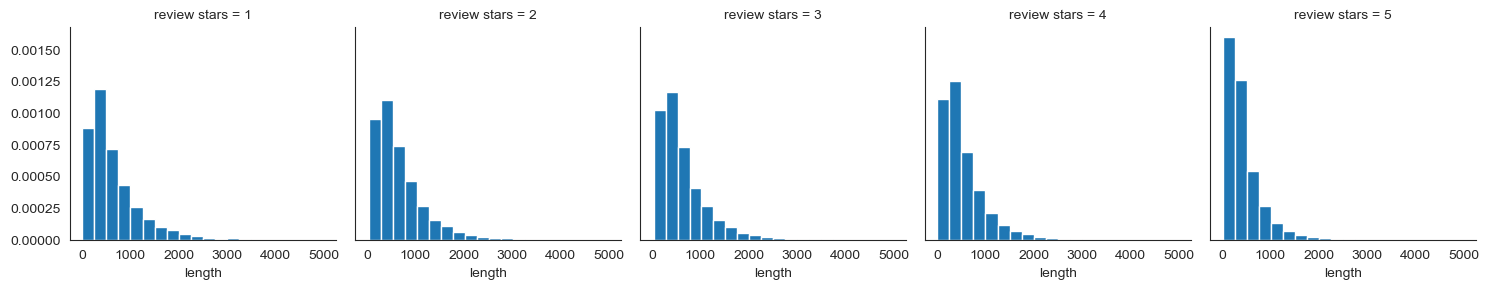

In [116]:
#Now we can ask: Are there visible correlations between review stars & text length (normalized)?
    #All seem to drop off around 2000 characters, but more 5-star reviews are relatively short
g = sns.FacetGrid(business_reviews, col='review stars')
g.map(plt.hist,'length', density=True, bins=20)

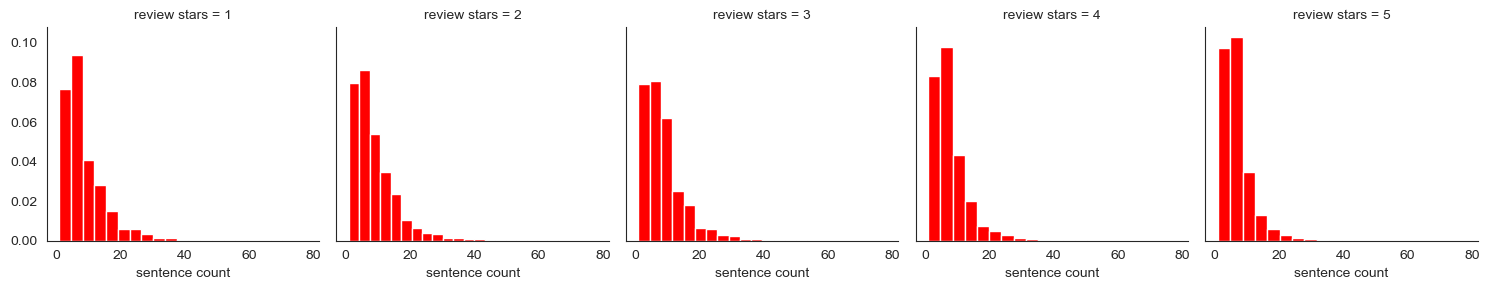

In [118]:
#What about with sentence count?
    #Again, 5-star seem shorter on average
g = sns.FacetGrid(business_reviews, col='review stars')
g.map(plt.hist,'sentence count', density=True, bins=20, color='red')

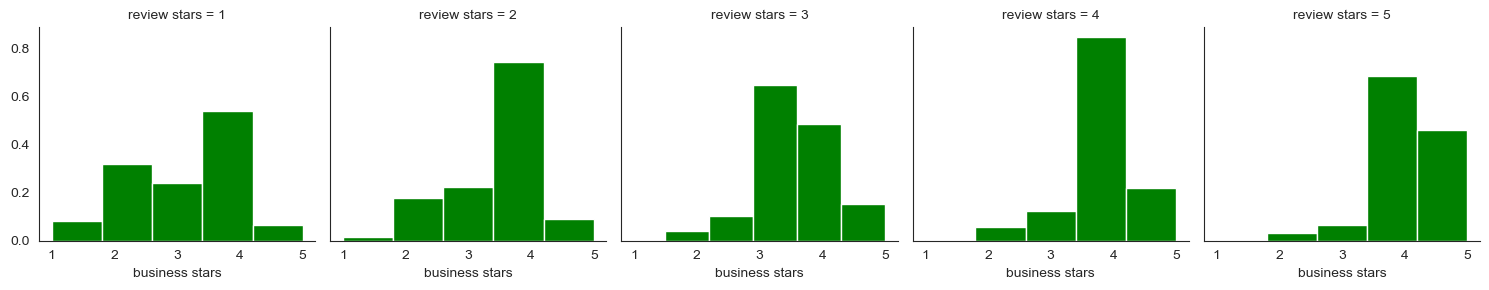

In [148]:
#What about with average stars for the business?
g = sns.FacetGrid(business_reviews, col='review stars')
g.map(plt.hist,'business stars', density=True, bins=5, color='green')

#There is a decent correlation between the review stars (target) and the average stars a business already has (business stars)
    #While there is potential for data leakage here, we'll be looking at millions of review in total
    #so we can begin with the assumption that one individual review wont significantly alter the average for business stars

Text(0, 0.5, 'average business stars')

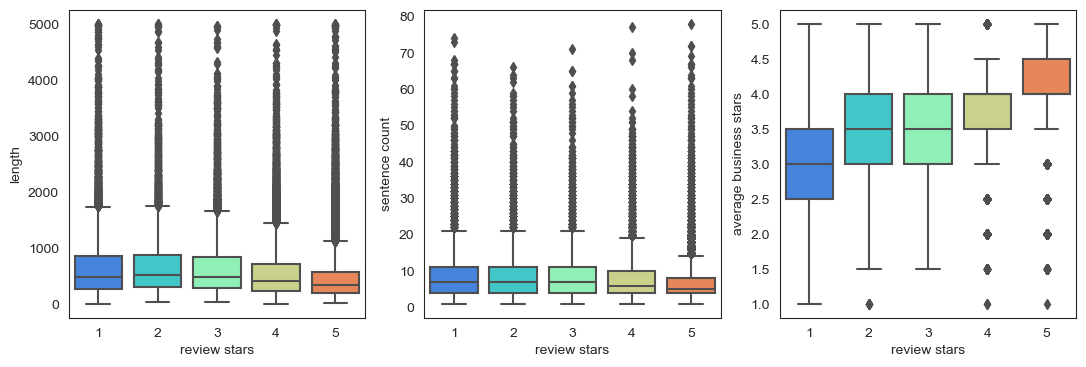

In [164]:
#Review stars vs. text length, sentence count, and business stars
    #There are some exceptionally lengthy reviews, which is why in the text processing above 
    #these were split into multiple parts
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,4))
sns.boxplot(x='review stars', y='length', data=business_reviews, palette='rainbow', ax=ax1)
sns.boxplot(x='review stars', y='sentence count', data=business_reviews, palette='rainbow', ax=ax2)
g = sns.boxplot(x='review stars', y='business stars', data=business_reviews, palette='rainbow', ax=ax3)
g.set_ylabel('average business stars')

#Very easy to see here that business stars correlate with review stars, but 1-star reviews are the most widely spread
    #There's always unhappy people no matter how well the business is rated

<Axes: xlabel='review stars', ylabel='hour'>

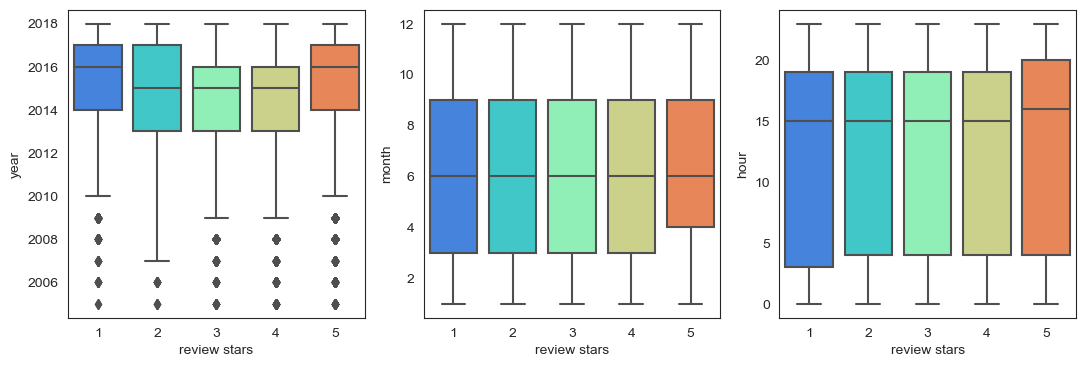

In [165]:
#Review stars vs. time
    #Not a large variation in how many stars a review receives based on specific times
    #Perhaps a small tendancy for 1-star reviews to occur earlier in the day and more
        #recently in history (year)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,4))
sns.boxplot(x='review stars', y='year', data=business_reviews, palette='rainbow', ax=ax1)
sns.boxplot(x='review stars', y='month', data=business_reviews, palette='rainbow', ax=ax2)
sns.boxplot(x='review stars', y='hour', data=business_reviews, palette='rainbow', ax=ax3)

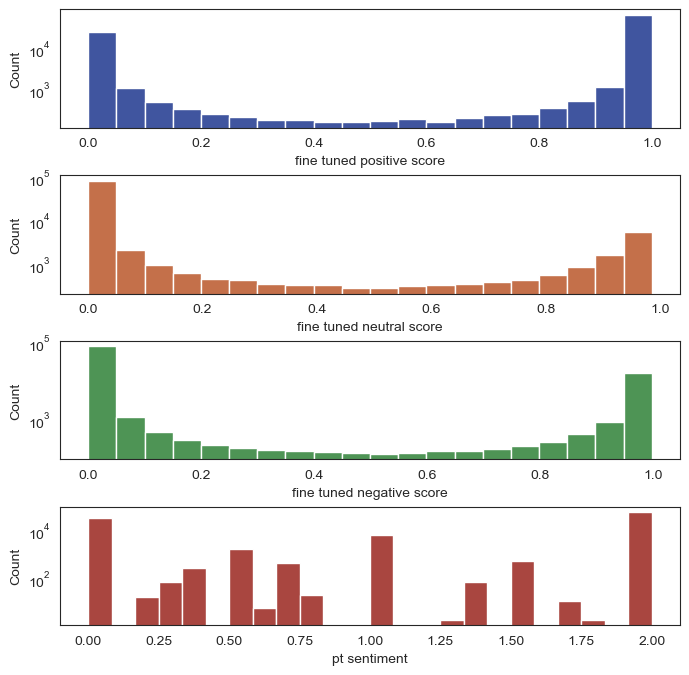

In [160]:
#Distributions of sentiments fine tuned bert vs. pretrained roBERTa sentiments

import itertools
palette = itertools.cycle(sns.color_palette('dark'))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(8,8))
plt.subplots_adjust(hspace=0.4)
g1 = sns.histplot(business_reviews['ft positive'], bins=20, color=next(palette), ax=ax1)
g2 = sns.histplot(business_reviews['ft neutral'], bins=20, color=next(palette), ax=ax2)
g3 = sns.histplot(business_reviews['ft negative'], bins=20, color=next(palette), ax=ax3)
g4 = sns.histplot(business_reviews['pt sentiment'], color=next(palette), ax=ax4)

g1.set_yscale('log')
g1.set_xlabel('fine tuned positive score')
g2.set_yscale('log')
g2.set_xlabel('fine tuned neutral score')
g3.set_yscale('log')
g3.set_xlabel('fine tuned negative score')
g4.set_yscale('log')
g4.set_xlabel('fine tuned positive score')

#We find that most of the time our fine tuned (ft) bert-base-uncased model will be close to 
#either 0 or 1 for each of positive, neutral, or negative
    #This is good, this indicates the features are mostly orthogonal and won't overlap
    #We have to plot on a log scale to even see the values in the middle

#The pretrained (pt) roBERTa has a mixture of sentiments from 0=negative, 1=neutral, to 2=positive
    #The mixed values between 0, 1, and 2 arise from mixing 0, 1, and 2 in longer review texts
    #that are split into multiple parts, evaluated separately, then averaged for an overall sentiment

## Finishing up exploratory analysis -  write preprocessed data

In [144]:
# Write the preprocessed dataframe which can be used in our XGBoost model later on
business_reviews.to_csv('../csv_processed/1_business_reviews.csv')

Next steps: follow these feature engineering steps for all 6.9 million reviews, fit with XGBoost, and extract meaningful sentiments from reviews